In [ ]:
#Importing the required libraries:
import os
import sys
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Hari/Evaluation/LensFinding/")
print("Changed directory to:", os.getcwd())  # Verify the change

Changed directory to: /content/drive/MyDrive/Hari/Evaluation/LensFinding


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Load train dataset
train_data = np.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/data/train_data.npz")
train_images, train_labels = train_data["images"], train_data["labels"]

# Load validation dataset
val_data = np.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/data/test_data.npz")
val_images, val_labels = val_data["images"], val_data["labels"]

# Split validation into val + test sets
from sklearn.model_selection import train_test_split
val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size=0.20, stratify=val_labels, random_state=42
)

# Identify lens images (Class 1)
lens_indices = np.where(train_labels == 1)[0]
lens_images = train_images[lens_indices]

# Define augmentations
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(3,3))
])


# Apply augmentations
num_augmentations = 5 #5 new lense images per original image
augmented_images = []
for img in lens_images:
    img_tensor = torch.tensor(img).float()
    for _ in range(num_augmentations):
        aug_img = transform(img_tensor).numpy()  # Apply augmentation
        augmented_images.append(aug_img)


# Convert augmented images to NumPy array
augmented_images = np.array(augmented_images)
print(f"Augmented images shape: {augmented_images.shape} and Number of augmented images: {len(augmented_images)}")

# Append augmented images and labels to train set
train_images = np.concatenate([train_images, augmented_images], axis=0)
train_labels = np.concatenate([train_labels, np.ones(len(augmented_images))], axis=0)  # Labels remain 1

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 200  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check a batch
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")
    break


Augmented images shape: (8650, 3, 64, 64) and Number of augmented images: 8650
Batch shape: torch.Size([200, 3, 64, 64]), Labels shape: torch.Size([200])


In this attempt of training I put to use data augmentation. Using some random augmentations as mentioned in the block/cell above, I will generate more images for the underrepresented class and taht will increase the underrepresented class's num of images. This may prove to be beneficial.

In [ ]:
print(f"Train set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {val_images.shape}, Labels: {val_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")

Train set: (39055, 3, 64, 64), Labels: (39055,)
Validation set: (15720, 3, 64, 64), Labels: (15720,)
Test set: (3930, 3, 64, 64), Labels: (3930,)


In [ ]:
sys.path.append("./src")
from model import ResNet32
from train import train_model

In [ ]:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet32().to(device)
end_time = time.time()
print(f"Model loaded! Time taken: {end_time - start_time:.2f} sec")

Model loaded! Time taken: 0.40 sec


In [ ]:
epochs = 20
learning_rate = 0.0001

In [ ]:
train_losses, val_losses, train_accs, val_accs, val_aucs = train_model(
    model, train_loader, val_loader, device, epochs, learning_rate
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training started!

 Epoch 1/20 started


Epoch 1 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 1 Training: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]


📊 [Epoch 1/20] Train Loss: 0.297422 | Train Acc: 0.521 | Val Loss: 1.212198 | Val Acc: 0.487 | Val AUC: 0.8987
Saved new best model with Val AUC: 0.8987

 Epoch 2/20 started


Epoch 2 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 2 Training: 100%|██████████| 196/196 [00:24<00:00,  7.98it/s]


📊 [Epoch 2/20] Train Loss: 0.244645 | Train Acc: 0.592 | Val Loss: 1.197894 | Val Acc: 0.623 | Val AUC: 0.9357
Saved new best model with Val AUC: 0.9357

 Epoch 3/20 started


Epoch 3 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 3 Training: 100%|██████████| 196/196 [00:25<00:00,  7.73it/s]


📊 [Epoch 3/20] Train Loss: 0.234597 | Train Acc: 0.630 | Val Loss: 1.202796 | Val Acc: 0.213 | Val AUC: 0.9324

 Epoch 4/20 started


Epoch 4 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 4 Training: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]


📊 [Epoch 4/20] Train Loss: 0.227674 | Train Acc: 0.663 | Val Loss: 1.180359 | Val Acc: 0.717 | Val AUC: 0.9108

 Epoch 5/20 started


Epoch 5 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 5 Training: 100%|██████████| 196/196 [00:25<00:00,  7.77it/s]


📊 [Epoch 5/20] Train Loss: 0.225301 | Train Acc: 0.681 | Val Loss: 1.146439 | Val Acc: 0.819 | Val AUC: 0.9379
Saved new best model with Val AUC: 0.9379

 Epoch 6/20 started


Epoch 6 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 6 Training: 100%|██████████| 196/196 [00:25<00:00,  7.71it/s]


📊 [Epoch 6/20] Train Loss: 0.221654 | Train Acc: 0.701 | Val Loss: 1.211178 | Val Acc: 0.491 | Val AUC: 0.9664
Saved new best model with Val AUC: 0.9664

 Epoch 7/20 started


Epoch 7 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 7 Training: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]


📊 [Epoch 7/20] Train Loss: 0.218925 | Train Acc: 0.738 | Val Loss: 1.144313 | Val Acc: 0.710 | Val AUC: 0.9696
Saved new best model with Val AUC: 0.9696

 Epoch 8/20 started


Epoch 8 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 8 Training: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]


📊 [Epoch 8/20] Train Loss: 0.215292 | Train Acc: 0.755 | Val Loss: 1.163816 | Val Acc: 0.142 | Val AUC: 0.9464

 Epoch 9/20 started


Epoch 9 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 9 Training: 100%|██████████| 196/196 [00:25<00:00,  7.68it/s]


📊 [Epoch 9/20] Train Loss: 0.212978 | Train Acc: 0.792 | Val Loss: 1.122925 | Val Acc: 0.872 | Val AUC: 0.8601

 Epoch 10/20 started


Epoch 10 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 10 Training: 100%|██████████| 196/196 [00:25<00:00,  7.67it/s]


📊 [Epoch 10/20] Train Loss: 0.209994 | Train Acc: 0.804 | Val Loss: 1.414597 | Val Acc: 0.241 | Val AUC: 0.9631

 Epoch 11/20 started


Epoch 11 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 11 Training: 100%|██████████| 196/196 [00:25<00:00,  7.68it/s]


📊 [Epoch 11/20] Train Loss: 0.207882 | Train Acc: 0.826 | Val Loss: 1.146439 | Val Acc: 0.580 | Val AUC: 0.9372

 Epoch 12/20 started


Epoch 12 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 12 Training: 100%|██████████| 196/196 [00:25<00:00,  7.61it/s]


📊 [Epoch 12/20] Train Loss: 0.206122 | Train Acc: 0.842 | Val Loss: 1.189676 | Val Acc: 0.760 | Val AUC: 0.9643

 Epoch 13/20 started


Epoch 13 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 13 Training: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]


📊 [Epoch 13/20] Train Loss: 0.201181 | Train Acc: 0.888 | Val Loss: 1.126946 | Val Acc: 0.875 | Val AUC: 0.9322

 Epoch 14/20 started


Epoch 14 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 14 Training: 100%|██████████| 196/196 [00:25<00:00,  7.70it/s]


📊 [Epoch 14/20] Train Loss: 0.200932 | Train Acc: 0.890 | Val Loss: 1.131866 | Val Acc: 0.823 | Val AUC: 0.9364

 Epoch 15/20 started


Epoch 15 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 15 Training: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]


📊 [Epoch 15/20] Train Loss: 0.199907 | Train Acc: 0.895 | Val Loss: 1.131278 | Val Acc: 0.870 | Val AUC: 0.9410

 Epoch 16/20 started


Epoch 16 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 16 Training: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]


📊 [Epoch 16/20] Train Loss: 0.199587 | Train Acc: 0.901 | Val Loss: 1.122229 | Val Acc: 0.882 | Val AUC: 0.9267

 Epoch 17/20 started


Epoch 17 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 17 Training: 100%|██████████| 196/196 [00:25<00:00,  7.70it/s]


📊 [Epoch 17/20] Train Loss: 0.199685 | Train Acc: 0.902 | Val Loss: 1.124472 | Val Acc: 0.829 | Val AUC: 0.9267

 Epoch 18/20 started


Epoch 18 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 18 Training: 100%|██████████| 196/196 [00:25<00:00,  7.62it/s]


📊 [Epoch 18/20] Train Loss: 0.199446 | Train Acc: 0.902 | Val Loss: 1.126272 | Val Acc: 0.867 | Val AUC: 0.9225

 Epoch 19/20 started


Epoch 19 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 19 Training: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]


📊 [Epoch 19/20] Train Loss: 0.199925 | Train Acc: 0.901 | Val Loss: 1.125495 | Val Acc: 0.865 | Val AUC: 0.9274

 Epoch 20/20 started


Epoch 20 Training:   0%|          | 0/196 [00:00<?, ?it/s]/content/drive/MyDrive/Hari/Evaluation/LensFinding/./src/train.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed-precision for efficiency
Epoch 20 Training: 100%|██████████| 196/196 [00:25<00:00,  7.68it/s]


📊 [Epoch 20/20] Train Loss: 0.198964 | Train Acc: 0.903 | Val Loss: 1.124784 | Val Acc: 0.864 | Val AUC: 0.9252


In [ ]:
print("Train_Losses : \n",train_losses)
print("Val_Losses :  \n",val_losses)
print("Train_Accs :  \n",train_accs)
print("Val_Accs :  \n",val_accs)
print("Val_AUCs : \n",val_aucs)

Train_Losses : 
 [0.29742207722968506, 0.24464452589860022, 0.23459703255945064, 0.22767419548212314, 0.2253007824542107, 0.22165427756338507, 0.21892498756947612, 0.21529200201706977, 0.21297758358104207, 0.20999418739517983, 0.20788197801034072, 0.2061221690958402, 0.20118084206324413, 0.20093152902027417, 0.19990704539124052, 0.1995872181286169, 0.199685115113925, 0.19944556403512642, 0.19992539161467365, 0.1989636335585368]
Val_Losses :  
 [1.212198328425866, 1.1978938188261659, 1.2027957447005895, 1.1803585281808868, 1.1464390505967856, 1.2111782022104918, 1.1443127733453844, 1.163815889498053, 1.1229249860797523, 1.4145967405260975, 1.1464390839632534, 1.1896762239720682, 1.126946488409552, 1.1318656676294847, 1.1312779003123898, 1.1222290410340288, 1.1244716732253253, 1.126271863930098, 1.1254949839667205, 1.124784384671665]
Train_Accs :  
 [0.5208039943669185, 0.5916271924209449, 0.6295224683139162, 0.6629624887978491, 0.6809371399308667, 0.7007297401101011, 0.7383433619254897,

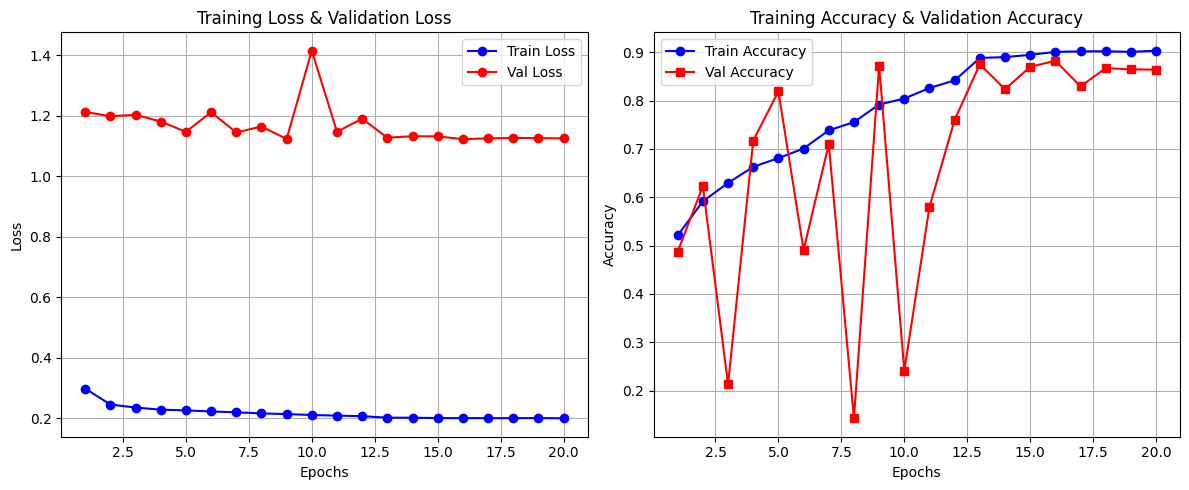

In [ ]:
epochs_ = range(1,len(train_losses)+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_losses, label="Train Loss", marker="o", color="blue")
plt.plot(epochs_, val_losses, label="Val Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss & Validation Loss")
plt.legend()
plt.grid(True)

# Plot Validation Loss & Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(epochs_, val_accs, label="Val Accuracy", marker="s", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Hari/Evaluation/LensFinding/results/best_model.pth"))

<All keys matched successfully>

In [ ]:
def evaluate(model, dataloader, device):
    """ Runs inference on the entire test dataset and computes accuracy & loss. """
    model.eval()  # Set model to evaluation mode
    total_loss, correct = 0, 0
    total_samples = 0

    with torch.no_grad():  # No gradients needed during inference
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            # Compute predictions
            preds = outputs.argmax(dim=1)  # Get class with highest probability
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item() * images.size(0)

    # Compute final metrics
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

test_loss, test_acc = evaluate(model, test_loader, device)
print(test_acc)

0.7048346055979644


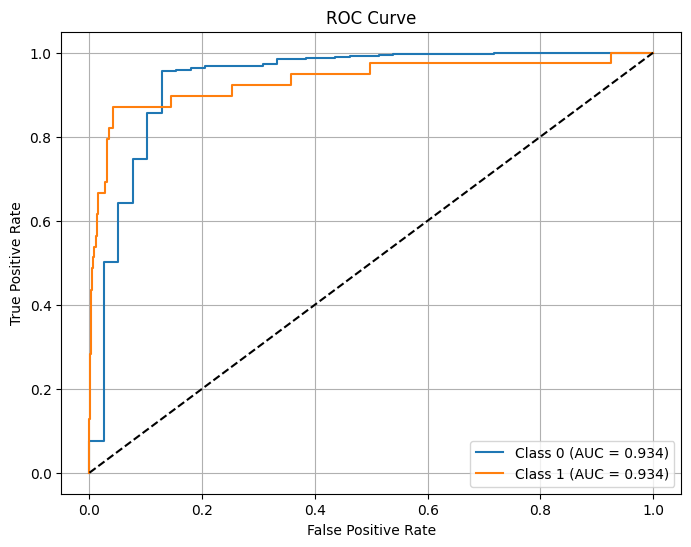

In [ ]:
#ROC and AUC analysis using sklearn :
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_auc_score

def compute_roc_auc(model, dataloader, device, num_classes=2):
    """Computes ROC curves and AUC scores for each class."""
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.cpu().numpy()  # Convert labels to NumPy
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities

            all_labels.extend(labels)
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    # Binarize labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        #class_probs = all_probs[:, i]
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])  # Binary classification for each class
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc, num_classes=2):
    """Plots ROC curves for each class."""
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line (random classifier)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

#Compute ROC & AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, device)

# Plot ROC Curves
plot_roc_curves(fpr, tpr, roc_auc)

Similar AUC Scores indicate that the model is classifying both the labels neraly in the same way.
But the test accuracy is still low at 71 %, even after data augmentation to make new lense images.For now I will increase the number of Augmented lense images and try to fix the wildly oscillating val loss and accuracy and see the results.We increased the test accuracy a bit. I will go for the next tarining and try to increase the accuracy by a bit more.